### Preprocessing data for tweet sentiment analysis

In [1]:
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import torch
import re

/Users/minkijung/anaconda3/envs/runpod/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained(
    "google/flan-t5-base",
    padding_side="left",  # putting paddings on left to predict the sentiment right after
)

In [3]:
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
print(f"==>> dataset: {dataset}")

==>> dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [4]:
# change the key label to labels
dataset = dataset.rename_column("label", "labels")
print(f"==>> dataset: {dataset}")

==>> dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2388
    })
})


In [5]:
# remove url from dataset
def remove_url(example):
    example["text"] = re.sub(r"https?://\S+", "", example["text"])
    return example

dataset = dataset.map(remove_url)

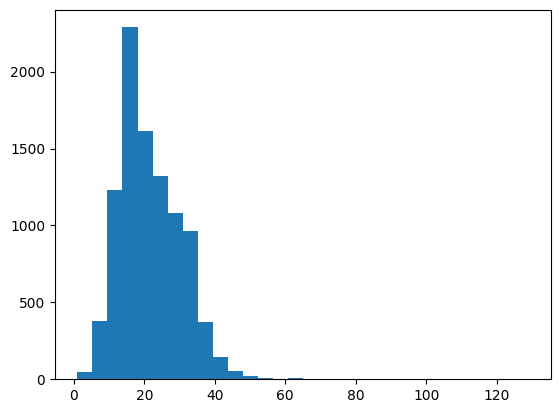

In [6]:
# Check the lengths of the each text
lengths = [
    len(tokenizer.encode(text))
    for text in dataset["train"]["text"] # consider only train since in real senario we only have train data
]

plt.hist(lengths, bins=30)
plt.show()

In [7]:
# show texts that is longer than 50 tokens
outliers = []
for element in dataset["train"]:
    if len(tokenizer.encode(element["text"])) > 50:
        outliers.append(element)

# sort the outliers by length of "text"
outliers = sorted(
    outliers, key=lambda x: len(tokenizer.encode(x["text"])), reverse=True
)

for outlier in outliers:
    print("length", len(tokenizer.encode(outlier["text"])))
    print(outlier["text"])
    print(outlier["labels"])
    print("----")

length 129
A Tokióban található teamLab Planets, a múzeum, ahol a víz a kiállítási közeg, idén tavasszal egy kis időre cseresznyevirág-szirmokba öltözik. A kiállítás 2020. március 1-től tekinthető meg.
2
----
length 81
Riassunto: Le giapponesi NEDO e Panasonic raggiungono il più alto rendimento di conversione al mondo, pari al 16,09%, per il modulo a celle solari perovskitiche dalla superficie più estesa
2
----
length 74
Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $ENR $EQM $ETRN $FE $HAS $HLX $JD $KIM $LYFT $NTR $NVDA $ORAN $PROS $SNAP $WEN $WING $WRI $ZS
1
----
length 68
Upgrades 4/7: $AMT $BHP $BK $CHH $ENI $EQNR $ETR $EXR $FCX $HOLX $HSIC $LOW $LSI $MAR $MAS $MGP $MHK $MXL $NGG $NWE… 
1
----
length 67
Samenvatting: Japanse NEDO en Panasonic behalen ‘s werelds hoogste conversie-efficiëntie van 16,09% voor grootste zonnecelmodule met Perovskite per gebied
2
----
length 66
+Initiations 11/25: $ARVN $AZRE $BHE $BMY-R $CHGG $EVR $FLXN $GBT $GOOS $IMBI $LULU $MMP $OPK $OYST $PRPL $QIWI… 


There are some non-Enlgish data. However, it will be the same in validation dataset. I'll leave them so that the model will be more robust to non-english data.

The indication of sentiment mostly locates in the begining of the sentence. Thus, I'll truncate text longer than 50. 

In [8]:
# token length of "TSA sentence: "
print(len(tokenizer.encode("TSA sentence: "))) # this is a prefix that I will use to predict the sentiment with T5 model

6


In [9]:
dataset["train"]["labels"]

# sort labels by length
sorted_labels = sorted(set(dataset["train"]["labels"]))
print(f"==>> sorted_labels: {sorted_labels}")

==>> sorted_labels: [0, 1, 2]


I'm going to add a prefix token which takes 6 tokens. So the max length will be 56

In [10]:
def tokenize_function(examples):

    examples_text = ["TSA sentence: " + text for text in examples["text"]]

    inputs = tokenizer(
        examples_text,
        padding="max_length",
        max_length=56,
        truncation=True,
        return_tensors="pt",
    )

    # tokenized labels to be used in training
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            [str(label) for label in examples["labels"]],
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=3,
        )

    inputs["labels"] = [label[1:] for label in labels["input_ids"]]

    return inputs


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]/Users/minkijung/anaconda3/envs/runpod/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 9543/9543 [00:00<00:00, 11023.02 examples/s]


In [11]:
tokenized_datasets["train"]["labels"][:3]

[[632, 1], [632, 1], [632, 1]]

In [12]:
#save the tokenized dataset
tokenized_datasets.save_to_disk("tokenized_datasets")

Saving the dataset (1/1 shards): 100%|██████████| 2388/2388 [00:00<00:00, 253261.81 examples/s]


In [13]:
# load the tokenized dataset
tokenized_datasets_new = load_from_disk("tokenized_datasets")
print(f"==>> tokenized_datasets: {tokenized_datasets_new}")

==>> tokenized_datasets: DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2388
    })
})


In [14]:

# check the tokenized dataset
print(tokenized_datasets_new["train"]["input_ids"][:2])
print("type of input_ids", type(tokenized_datasets_new["train"]["input_ids"]))
# print(tokenized_datasets_new["train"]["attention_mask"][:3])


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 332, 4507, 7142, 10, 1514, 279, 476, 10604, 3, 18, 446, 6218, 11127, 14495, 7, 16, 4454, 30, 13594, 1212, 144, 3, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 332, 4507, 7142, 10, 1514, 2823, 434, 1514, 4902, 434, 3, 18, 465, 11054, 9, 979, 12, 5038, 7, 18724, 44, 26813, 11, 3671, 12802, 3, 1]]
type of input_ids <class 'list'>


In [15]:
print(tokenized_datasets_new["train"]["labels"][:3])

[[632, 1], [632, 1], [632, 1]]


In [18]:
token_length = [len(tokens) for tokens in tokenized_datasets_new["train"]["input_ids"]]
print("unique token lengths", set(token_length))

unique token lengths {56}
